<center><h1>The Transformer Epiphany Speech - Vision - Text Workshop<h1>

---
*Organized by AI Club NIT-Calicut* 

# **Image Generation using VQ-VAE and GPT**




### ***Introduction***

The goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The fundamental difference between a VAE and a VQ-VAE is that VAE learns a continuous latent representation, whereas VQ-VAE learns a discrete latent representation.

we know how continuous vector spaces can be used to represent the latents in an autoencoder. But latents do not necessarily need to be continuous vectors, it really just needs to be some numerical representation for the data. And one such, potentially desirable, alternative to a vector space is a discrete representation.

Many important real-world objects are discrete and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continuous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

A lot of the data we encounter in the real world favors a discrete representation. For example, human speech is well represented by discrete phonemes and language. Additionally, images contain discrete objects with some discrete set of qualifiers. You could imagine having one discrete variable for the type of object, one for its color, one for its size, one for its orientation, one for its shape, one for its texture, one for the background color, one for the background texture, etc…

In addition to the representation, there are a number of algorithms (like transformers) that are designed to work on discrete data, so we would like to have a discrete representation of the data for these algorithms to use.

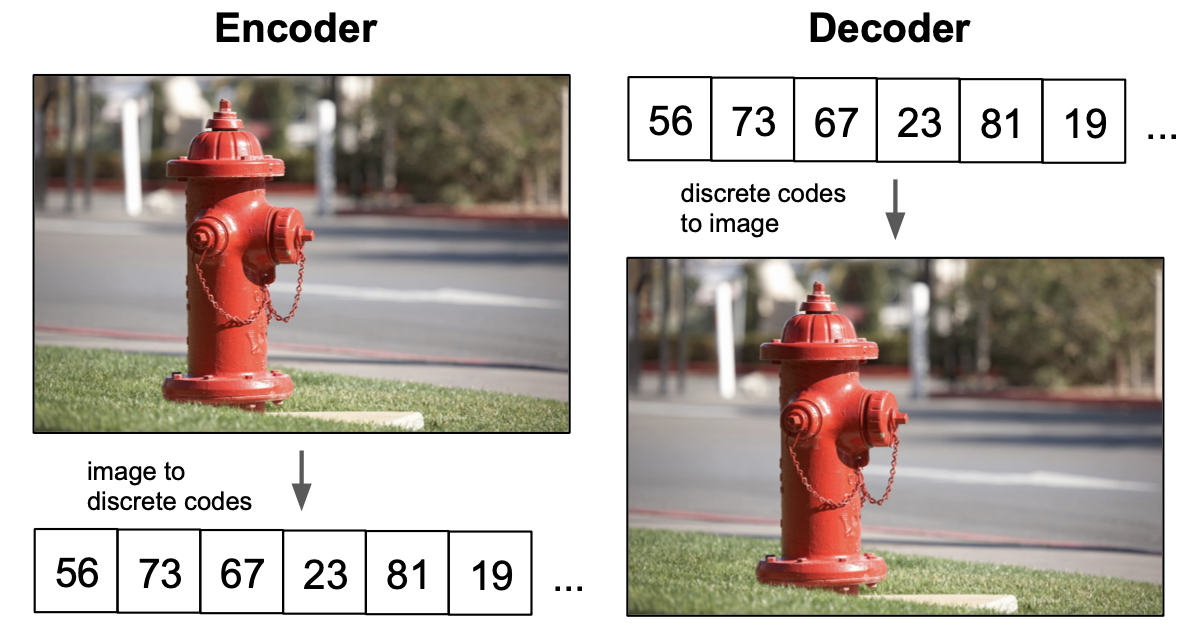


**Basic Idea**

The overall architecture is summarized in the diagram below:

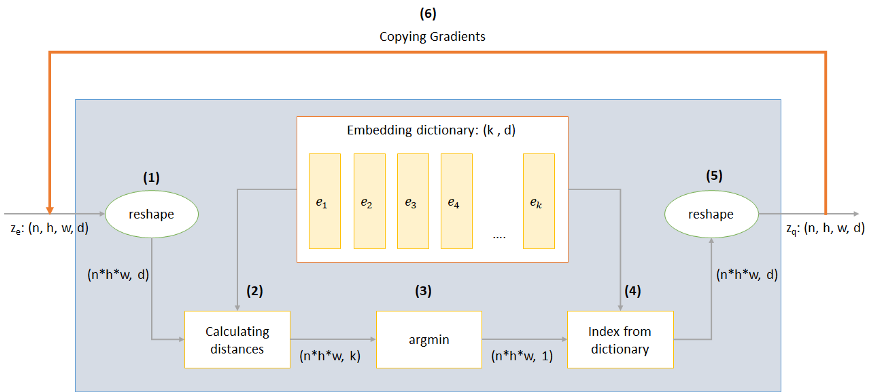

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector, i.e. $e_i \in \mathbb{R}^{D}$. The model is comprised of an encoder and a decoder. The encoder will map the input to a sequence of discrete latent variables, whereas the decoder will try to reconstruct the input from these latent sequences. 

More preciesly, the model will take in batches of RGB images,  say $x$, each of size 224×224 for our example, and pass it through a ConvNet encoder producing some output $E(x)$, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index. 

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image. 

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

**Loss**

The total loss is actually composed of three components

1. **reconstruction loss**: which optimizes the decoder and encoder
1. **codebook loss**: due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. **commitment loss**:  since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

### ***VQ-VAE Coding Section***

#### **Pip Python Package Installation**

In [ ]:
%%capture
!pip install timm

#### **Imports**

In [ ]:
import os
import cv2
import timm
import torch
import torchvision
import numpy as np
import collections
from torch import nn
import seaborn as sns
from torch.nn import functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#### **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


#### **Setting up GPU**

In [ ]:
#sets device to cuda if GPU is available else to cpu
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#### **Defining Sub-Modules**

##### **ResidualBlock**
>1. Deeper neural networks are more difficult to train.One big problem of a deep network is the vanishing gradient problem.

>2. In ResidualBlocks, the output from the previous layer, called residual, is added to the output of the current layer. The following picture visualizes this operation.



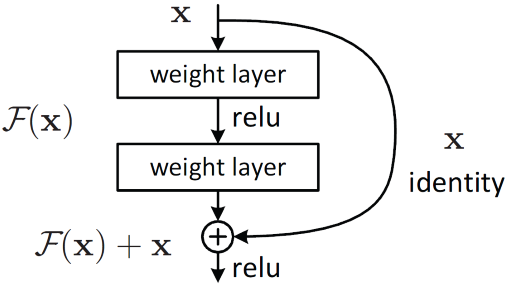

**Pytorch code implementation**

In [ ]:
class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, in_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, in_dim, kernel_size=1,
                      stride=1, bias=False)
        )
        
    def forward(self, x):
        x = x + self.res_block(x)
        x = F.relu(x)
        return x

##### **Residual Stack**

> Multiple Residual Blocks are stacked upon each other to form a residual stack.The following picture visualizes this operation.



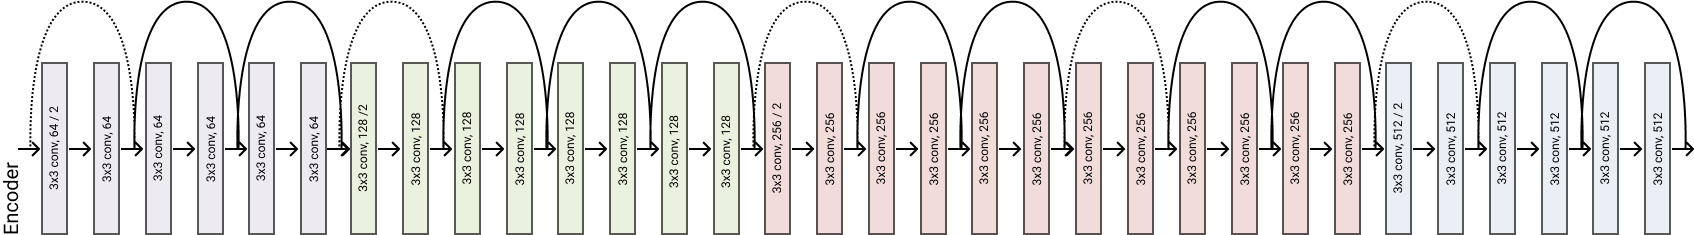

**Pytorch code implementation**

In [ ]:
class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, res_h_dim)]*n_res_layers)           #Adding Multiple Residual blocks into the list
        self.conv = nn.Conv2d(in_dim, h_dim, kernel_size=1)

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(self.conv(x))
        return x

**Defining Encoder, Decoder and CodeBook**

#### **Encoder, Decoder and Quantizer**

##### **Encoder**

Resnet is used as encoder and is implemented below:

**Pytorch code implementation**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, backbone = 'resnet34'):                          #Choosing resnet34 as our default backbone for this task
        super(Encoder, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained = True)  #Load a pretrained Resnet34 network
        self.List = list(self.backbone.children())[:-4]                 #creating a subset of layers from the resnet34 network
    def forward(self,X):
        for i,layer in enumerate(self.List):                            #Forward pass our input through each encoder layer
            X = layer(X)
        return X 

##### **Vector Quantizer Layer**

>This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

>The output tensor will have the same shape as the input.

>For example for a `BCHW` tensor of shape `[90, 128, 28, 28]`, we will first convert it to an `BHWC` tensor of shape `[90, 28, 28, 128]` and then reshape it into `[70560, 128]` and all `70560` vectors of size `128`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `70560` in this case.

**Pytorch code implementation**

In [ ]:
class discretize(nn.Module):
    def __init__(self, n_e, e_dim, beta=0.25):
        super(discretize, self).__init__()
        self.e_dim = e_dim                              # size of each codebook vector
        self.n_e = n_e                                  # Size of codebook or number of vectors in the quantized space.
        self.beta = beta                                # scalar which controls the weighting of the loss terms
        self.code_book = nn.Embedding(n_e, e_dim)
        self.softmax = nn.Softmax(dim=1)
        self.code_book.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, enc):
        # convert inputs from BCHW -> BHWC and flatten
        enc = enc.permute(0,2,3,1).contiguous()
        enc_flattened = enc.view(-1, self.e_dim)

        # distances from enc_flattened(z) to embeddings(e)   
        # (z - e)**2 = z**2 + e**2 - 2*e*z
        distances = (torch.sum(enc_flattened**2, dim=1, keepdim = True)+
                     torch.sum(self.code_book.weight**2, dim=1)
                        -2*torch.matmul(enc_flattened, self.code_book.weight.t()))
        # find closest encodings
        min_encoding_ids = torch.argmin(distances, dim=1).unsqueeze(1)
        min_encodings_mask = torch.zeros(min_encoding_ids.shape[0], self.n_e, dtype = self.code_book.weight.dtype).to(enc.device)
        min_encodings_mask.scatter_(1, min_encoding_ids, 1)

        # get quantized latent vectors
        latent_reps = torch.matmul(min_encodings_mask, self.code_book.weight).view(enc.shape)

        # compute loss for embedding
        codebook_loss = F.mse_loss(latent_reps.detach(),enc) + self.beta * F.mse_loss(latent_reps , enc.detach())

        # copy gradients from decoder to encoder
        latent_reps = enc + (latent_reps-enc).detach()

        # calculate perplexity
        e_mean = torch.mean(min_encodings_mask, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # convert quantized from BHWC -> BCHW
        latent_reps = latent_reps.permute(0, 3, 1, 2).contiguous()

        return latent_reps, codebook_loss, perplexity

##### **Decoder**

The decoder architecture is based on a Residual blocks and is implemented below:

**Pytorch code implementation**

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, stride = 2):
        super(Decoder, self).__init__()
        self.upsample1 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)
        self.upsample3 = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
        self.conv1 = ResidualStack(128, 64, 256,2)
        self.conv2 = ResidualStack(64, 32, 128,3)
        self.conv3 = ResidualStack(32, 16, 64,3)
        self.conv4 = ResidualStack(16, 8, 32,3)
        self.conv5 = nn.Conv2d(8, 3, kernel_size=1,
                      stride=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,X):
        X = self.conv1(X) 
        X = self.upsample1(X, output_size=(X.size(0),X.size(1),X.size(2)*2,X.size(3)*2))        #56
        X = self.conv2(X) 
        X = self.upsample2(X, output_size=(X.size(0),X.size(1),X.size(2)*2,X.size(3)*2))       #112
        X = self.conv3(X)
        X = self.upsample3(X, output_size=(X.size(0),X.size(1),X.size(2)*2,X.size(3)*2))       #224
        X = self.conv4(X)
        X = self.conv5(X)
        return self.sigmoid(X)

#### **Print Summary of Models**

In [ ]:
dummy_encoder = Encoder().to(DEVICE)
dummy_decoder = Decoder().to(DEVICE)
summary(dummy_encoder, (3, 224, 224))
summary(dummy_decoder, (128, 28, 28))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /root/.cache/torch/hub/checkpoints/resnet34-43635321.pth


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### **Defining DataLoaders**

In [ ]:
class BirdDataset(Dataset):

    def __init__(self, img_pths, device = "cpu"):
        self.device = device
        self.img_pths = img_pths

    def __len__(self):
        return len(self.img_pths)
    
    def __getitem__(self, id):
        img = cv2.imread(self.img_pths[id], cv2.IMREAD_COLOR)
        img_input = img/255.0
        img_input = np.moveaxis(img_input, 2, 0)
        img_input = torch.tensor(img_input, dtype = torch.float).to(self.device)
        return img_input

#### **Defining Perceptual Loss**

**Pytorch code implementation**

In [ ]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
            
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406], device='cuda').view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225], device='cuda').view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss

#### **Defining Trainer**

In [ ]:
class Trainer:
    def __init__(self, encoder, discrete, decoder, optimizer,scheduler, device = DEVICE, load_pretrained=True):
        self.encoder = encoder
        self.discrete = discrete
        self.decoder = decoder
        self.device = device
        self.perceptual_loss = VGGPerceptualLoss().to(self.device)
        self.mse = nn.MSELoss()
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.best_loss = None
        if load_pretrained:
            self.load()

    def fit(self, train_loader, l, epoch):
        train_loader = tqdm(train_loader)
        train_loader = enumerate(train_loader)
        c_loss = 0
        r_loss = 0
        p = 0
        self.encoder.train()
        self.discrete.train()
        self.decoder.train()
        for i,X in train_loader:
            enc = self.encoder(X)
            latent_reps, codebook_loss, perplexity = self.discrete(enc)
            final_image = self.decoder(latent_reps)
            
            self.optimizer.zero_grad()
            perceptual_loss = self.perceptual_loss(final_image*255.0,X*255.0)
            mse_loss = self.mse(final_image*255.0,X*255.0)
            recon_loss =  perceptual_loss + mse_loss
            recon_loss.backward()
            self.optimizer.step()

            c_loss+=codebook_loss.detach().item()
            r_loss+=recon_loss.detach().item()
            p+=perplexity.detach().item()
        c_loss/=(i+1)
        recon_loss/=(i+1)
        p/=(i+1)
        print("Epoch: {} | Codebook_loss : {} | Recon_loss : {} | Perplexity : {} |".format(epoch, c_loss, recon_loss, p))
        self.save(recon_loss)
        self.scheduler.step(c_loss+recon_loss)

    def test(self, train_loader, epoch):
        for X in train_loader:
            break
        self.encoder.eval()
        self.discrete.eval()
        self.decoder.eval()
        i = random.choice([i for i in range(X[0].size()[0])])
        with torch.no_grad():
            latent_reps, codebook_loss, perplexity = self.discrete(self.encoder(X))
            output = self.decoder(latent_reps)
        output_1 = output.detach().cpu().numpy()[i]
        X_1 = X.cpu().numpy()[i]
        X_1 = np.transpose(X_1, [2,1,0])
        output_1 = np.transpose(output_1, [2,1,0])
        X_1 = np.asarray(X_1*255.0, dtype = np.int32)
        output_1 = np.asarray(output_1*255.0, dtype = np.int32)
        fig,a =  plt.subplots(2,2,figsize=(10,10))
        a[0][0].imshow(X_1)
        a[0][0].set_xticks([])
        a[0][0].set_yticks([])
        a[0][1].imshow(output_1)
        a[0][1].set_xticks([])
        a[0][1].set_yticks([])
        output_2 = output.detach().cpu().numpy()[i+1]
        X_2 = X.cpu().numpy()[i+1]
        X_2 = np.transpose(X_2, [2,1,0])
        output_2 = np.transpose(output_2, [2,1,0])
        X_2 = np.asarray(X_2*255.0, dtype = np.int32)
        output_2 = np.asarray(output_2*255.0, dtype = np.int32)
        a[1][0].imshow(X_2)
        a[1][0].set_xticks([])
        a[1][0].set_yticks([])
        a[1][1].imshow(output_2)
        a[1][1].set_xticks([])
        a[1][1].set_yticks([])
        plt.savefig("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/reconstructions/test_{}.png".format(epoch))
        plt.show()

    def save(self,loss):
        if self.best_loss == None:
            self.best_loss = loss
            torch.save(self.encoder.state_dict(), "/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/encoder.pth")
            torch.save(self.discrete.state_dict(), "/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/discrete.pth")
            torch.save(self.decoder.state_dict(), "/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/decoder.pth")
            print("weight saved!!")
            
        elif loss < self.best_loss:
            self.best_loss = loss
            torch.save(self.encoder.state_dict(), "/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/encoder.pth")
            torch.save(self.discrete.state_dict(), "/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/discrete.pth")
            torch.save(self.decoder.state_dict(), "/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/decoder.pth")
            print("weight saved!!")
    
    def load(self):
        print("loading weights...")
        self.encoder.load_state_dict(torch.load("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/encoder.pth"))
        self.discrete.load_state_dict(torch.load("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/discrete.pth"))
        self.decoder.load_state_dict(torch.load("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/decoder.pth"))
        print("weights loaded..")

#### **Collecting Paths from the Dataset**

In [ ]:
root_pth = "/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/train/"
birds_folders = os.listdir(root_pth)
img_pths = []
for folder in birds_folders:
    folder_pth = root_pth+folder
    files = os.listdir(folder_pth)
    for f in files:
        file_pth = folder_pth + "/" + f
        img_pths.append(file_pth)

In [ ]:
len(img_pths)

39367

#### **Visualizing Image from Dataset**

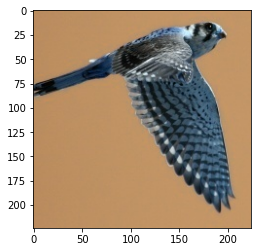

In [ ]:
import random
import matplotlib.pyplot as plt
dummy = random.choice(img_pths)
plt.imshow(cv2.imread(dummy))
plt.show()

#### **Initializing Dataloader**

In [ ]:
BD = BirdDataset(img_pths, device = DEVICE)
l = len(BD)
train_dataloader = DataLoader(BD,
                              batch_size = 90,
                              shuffle = True)

#### **Initializing Models**

In [ ]:
encoder = Encoder().to(DEVICE)
discrete = discretize(512, 128).to(DEVICE)
decoder = Decoder().to(DEVICE)

#### **Initializing Optimizer, Schedulers and Trainer**

**Pytorch code implementation**

In [ ]:
optimizer = Adam([{'params': list(encoder.parameters())+list(decoder.parameters())},
                {'params': list(discrete.parameters()), 'lr': 1e-1}
            ], lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5,patience=5,verbose=True)
trainer = Trainer(encoder, discrete, decoder, optimizer, scheduler, load_pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

loading weights...
weights loaded..


In [ ]:
training = False
Validating = True

#### **Training**

In [ ]:
if training:
    for epoch in range(200):
        trainer.test(train_dataloader, epoch)
        trainer.fit(train_dataloader, l, epoch)

#### **View Reconstructions**

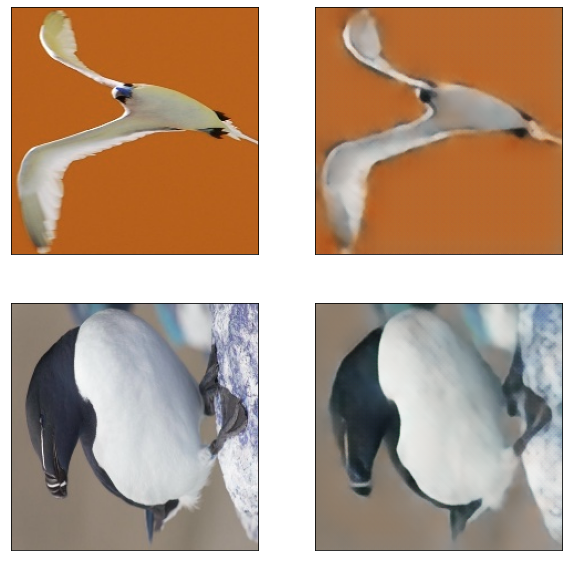

In [ ]:
if Validating:
    for epoch in range(1):
        trainer.test(train_dataloader, epoch)

### ***Data Preprocessing for Prior Learning***

#### **Load Pretrained Weights**

In [ ]:
encoder.load_state_dict(torch.load("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/encoder.pth", map_location = DEVICE))
discrete.load_state_dict(torch.load("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/discrete.pth", map_location = DEVICE))

<All keys matched successfully>

#### **Save CodeBook**

In [ ]:
code_book = np.array(discrete.code_book.weight.data.cpu())
np.save('/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/codebook.npy', code_book)

#### **Generate and save Discreate Latent Vectors**

In [ ]:
root_pth = "/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/train/"
birds_folders = ["RAINBOW LORIKEET"]#,"PINK ROBIN","AMERICAN GOLDFINCH","AFRICAN CROWNED CRANE","BALD EAGLE","PEACOCK","ROYAL FLYCATCHER","PUFFIN","TOUCHAN","PYGMY KINGFISHER"]
img_pths = []
for folder in birds_folders:
    folder_pth = root_pth+folder
    files = os.listdir(folder_pth)
    for f in files:
        file_pth = folder_pth + "/" + f
        img_pths.append(file_pth)

In [ ]:
imgs_size_in_bytes = 0
latent_size_in_bytes = 0
for img_pth in tqdm(img_pths):
    imgs_size_in_bytes+=os.path.getsize(img_pth)
    img = np.moveaxis(cv2.imread(img_pth),2 ,0)[np.newaxis, :,:,:]
    img = torch.tensor(img, dtype = torch.float).to(DEVICE)
    img = img/255.0
    enc = encoder(img)
    d_latent,_,_ = discrete(enc)
    ids = d_latent.detach().cpu().numpy()
    id_file_name = img_pth.split("/")[-2]+"_"+img_pth.split("/")[-1].split(".")[0]
    np.save("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/latent_data/"+id_file_name+".npy", ids)
    latent_size_in_bytes+=os.path.getsize("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/latent_data/"+id_file_name+".npy")

  0%|          | 0/141 [00:00<?, ?it/s]

In [ ]:
print("size of original dataset : {}". format(imgs_size_in_bytes))
print("size of compressed dataset : {}".format(latent_size_in_bytes))

size of original dataset : 3232998
size of compressed dataset : 56616576


In [ ]:
compression_ratio = imgs_size_in_bytes/latent_size_in_bytes
print(compression_ratio)

0.05710338258534038


### ***Learning Prior***

####**What is Prior?**

Once a VQ-VAE is fully trained, we can abandon the uniform prior imposed at training time and learn a new, updated prior p(z) over the latents. If we learn a prior that accurately represents the distribution of discrete codes, we will be able to generate new data from the distribution by sampling from this prior and feeding the samples to the decoder

Assuming the encoder outputs a sequence of latent codes for each datapoint, we can use any autoregressive model we want (i.e. RNN or transformer) to train the prior. The autoregressive factorization is, given all previous latent codes in the sequence, predict the next one. This breaks the latent distribution down as 

`p(z)=p(z1)p(z2|z1)p(z3|z1,z2)p(z4|z1,z2,z3)...,` where zi is the ith latent in the sequence.

If we are working with a 1-d signal like audio, casting the problem into an autoregressive form is very simple: just predict the next latent in the 1-d sequence encoded from the audio. For images we can cast the problem similarly, by first rolling out the 28x28 grid of latents into a 1-d sequence, such that the sequence goes from top left to bottom right, we can then apply autoregressive learning to this sequence.

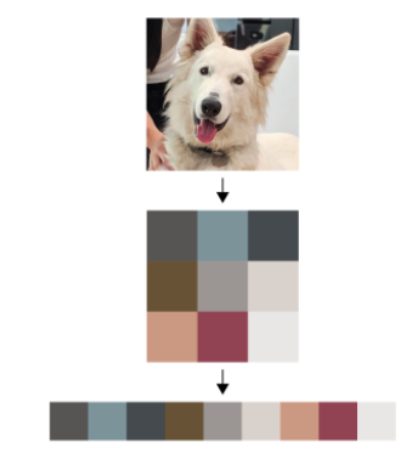
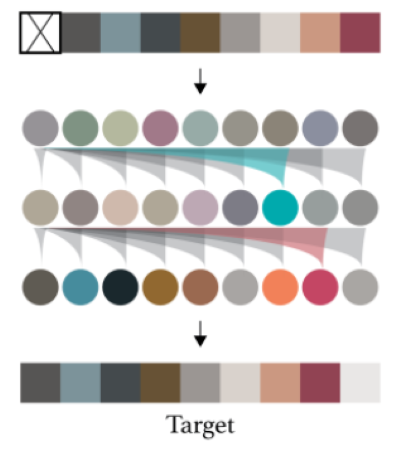

#### **Collecting Paths from the Dataset**

In [ ]:
root_dir="/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/latent_data"
list_files = os.listdir(root_dir)
files = []
class_id = []
classes = ["RAINBOW LORIKEET"]#,"PINK ROBIN","AMERICAN GOLDFINCH","AFRICAN CROWNED CRANE","BALD EAGLE","PEACOCK","ROYAL FLYCATCHER","PUFFIN","TOUCHAN","PYGMY KINGFISHER"]
for i in list_files:
    if i.split("_")[0] in classes:
        files.append(i)
        class_id.append(classes.index(i.split("_")[0]))
files = [root_dir + "/" + f for f in files]

#### **Train-Validation Split**

In [ ]:
train_dataset,val_dataset,train_clsid,valid_clsid = train_test_split(files,class_id, test_size=0.1, random_state=42,shuffle = True,stratify = np.array(class_id))

#### **Prior DataLoader**

In [ ]:
class PriorDataset(Dataset):
    def __init__(self, dataset, mode = "training"):
        self.files = dataset
        print("{} files found for {}".format(len(self.files),mode))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        rep = np.load(file)[:,0]
        Y = torch.tensor(rep)
        rep = np.concatenate([np.asarray(512).reshape(1),rep], axis=0)
        X = torch.tensor(rep[:-1])
        return X,Y

#### **GPT Sub-Modules**

##### **Attention Block**

**Pytorch code implementation**

In [ ]:
max_len = 5
mask = torch.tril(torch.ones(max_len, max_len)).unsqueeze(0).unsqueeze(0)
mask

tensor([[[[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]]]])

In [ ]:
seq_len = 3
mask = mask[:, :, :seq_len, :seq_len]
mask

tensor([[[[1., 0., 0.],
          [1., 1., 0.],
          [1., 1., 1.]]]])

In [ ]:
# attn.shape == (batch_size, num_heads, seq_len, seq_len)
batch_size = 3
num_heads = 3
attn = torch.randn(batch_size, num_heads, seq_len, seq_len)
attn.shape

torch.Size([3, 3, 3, 3])

In [ ]:
attn = attn.masked_fill(mask == 0, float("-inf"))
attn

tensor([[[[ 0.1843,    -inf,    -inf],
          [ 1.2818,  0.3564,    -inf],
          [-0.5413, -0.1989, -0.1568]],

         [[-0.6949,    -inf,    -inf],
          [-0.0647, -0.1229,    -inf],
          [ 1.4080, -0.0683,  0.2481]],

         [[-0.3176,    -inf,    -inf],
          [ 0.1540,  1.2216,    -inf],
          [-1.2303,  0.8133, -0.3861]]],


        [[[-0.4351,    -inf,    -inf],
          [-0.7366,  0.3578,    -inf],
          [-0.4024, -2.2116,  1.1537]],

         [[-1.6555,    -inf,    -inf],
          [ 1.1443,  0.2554,    -inf],
          [-0.3773,  0.7518, -0.0312]],

         [[-0.2843,    -inf,    -inf],
          [-1.8787,  0.9756,    -inf],
          [ 0.5316,  0.1459,  1.8845]]],


        [[[ 1.8747,    -inf,    -inf],
          [-1.0163,  2.0882,    -inf],
          [-1.3569, -2.2057, -0.8462]],

         [[-0.5000,    -inf,    -inf],
          [ 0.6623, -0.1552,    -inf],
          [ 0.2400, -0.0461, -0.2929]],

         [[-1.2776,    -inf,    -inf],
     

In [ ]:
class selfAttention(nn.Module):
    def __init__(self, config):
        super(selfAttention, self).__init__()

        self.key_layer = nn.Linear(config.embedding_dim, config.embedding_dim)
        self.query_layer = nn.Linear(config.embedding_dim, config.embedding_dim)
        self.value_layer = nn.Linear(config.embedding_dim, config.embedding_dim)

        self.attn_dropout = nn.Dropout(config.attn_drop)
        self.res_dropout = nn.Dropout(config.res_drop)

        self.mlp = nn.Linear(config.embedding_dim, config.embedding_dim)
        
        self.register_buffer("mask", torch.tril(torch.ones(config.max_size, config.max_size))
                                     .view(1, 1, config.max_size, config.max_size))
        self.n_heads = config.num_heads

    def forward(self, X):
        B, T, C = X.size()
        k = self.key_layer(X).view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)
        v = self.value_layer(X).view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)
        q = self.query_layer(X).view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)

        att = (q @ k.transpose(-2, -1))*(1/k.size(-1)**0.5)
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))

        att = F.softmax(att, dim = -1)
        att = self.attn_dropout(att)
        transformed = att @ v
        transformed = transformed.transpose(1,2).contiguous().view(B,T,C)
        transformed = self.mlp(transformed)
        transformed = self.res_dropout(transformed)
        return transformed

##### **Encoder Block**

**Pytorch code implementation**

In [ ]:
class buildingBlock(nn.Module):
    def __init__(self, config):
        super(buildingBlock, self).__init__()
        
        self.layernorm1 = nn.LayerNorm(config.embedding_dim)
        self.layernorm2 = nn.LayerNorm(config.embedding_dim)

        self.attention_layer = selfAttention(config)

        self.mlp = nn.Sequential(
            nn.Linear(config.embedding_dim, 4 * config.embedding_dim),
            nn.GELU(),
            nn.Linear(4 * config.embedding_dim, config.embedding_dim),
            nn.Dropout(config.res_drop),
        )

    def forward(self, X):
        X = X + self.attention_layer(self.layernorm1(X))
        X = X + self.mlp(self.layernorm2(X))
        return X

#### **GPT Config**

In [ ]:
class GPTconfig:
    def __init__(self, vocab_size, embedding_dim, num_layers, num_heads, max_size,
                 attn_drop, res_drop,
                 device):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.max_size = max_size
        self.attn_drop = attn_drop
        self.res_drop = res_drop
        self.device = device

#### **GPT-2 Model**

**Pytorch code implementation**

In [ ]:
%%capture
class GPT(nn.Module):
    def __init__(self, config):
        super(GPT, self).__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, config.max_size, config.embedding_dim))
        self.embedding_layer = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.drop = nn.Dropout(config.res_drop)
        self.blocks = nn.Sequential(*[buildingBlock(config) for i in range(config.num_layers)])

        self.layernorm = nn.LayerNorm(config.embedding_dim)
        self.mlp = nn.Linear(config.embedding_dim, config.vocab_size-1)
        self.to(config.device)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, X, y=None):
        b, t = X.size()
        X = self.embedding_layer(X)
        pos_embed = self.pos_embedding[:,:t,:]
        X = self.drop(pos_embed+X)
        X = self.blocks(X)
        X = self.layernorm(X)
        logits = self.mlp(X)
        if y is not None:
            loss = self.focal_loss(logits.view(-1, logits.size(-1)), y.view(-1))
        else:
            loss = 0
        return logits, loss

#### **Defining Trainer for Prior**

In [ ]:
class Trainer:
    def __init__(self, model, optimizer,scheduler, train_dataloader,
                 valid_dataloader = None, load_pretrained = True,
                 device = "cpu", use_scheduler = True):

        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.load_pretrained = load_pretrained
        self.device = device
        self.best_loss = None
        self.use_scheduler = use_scheduler
        self.codebook = torch.from_numpy(np.load("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/codebook.npy"))

        self.decoder = Decoder().to(self.device)
        self.decoder.load_state_dict(torch.load("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_VQVAE/decoder.pth", map_location = self.device))
        self.decoder.eval()

        if self.load_pretrained:
            self.load_weights("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_GPT2/GPT_conditioned.pth")

    def train_one_epoch(self):
        train_loss = 0
        dataloader = enumerate(tqdm(self.train_dataloader))
        self.model.train()
        for i,(X,Y) in dataloader:
            X = X.to(self.device)
            Y = Y.to(self.device)
            y_pred, loss = self.model(X,Y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss+=loss.item()
        train_loss/=(i+1)
        return train_loss

    def valid_one_epoch(self):
        valid_loss = 0
        dataloader = enumerate(tqdm(self.valid_dataloader)) 
        self.model.eval()
        for i,(X,Y) in dataloader:
            X = X.to(self.device)
            Y = Y.to(self.device)
            with torch.no_grad():
                y_pred, loss = self.model(X,Y)
            valid_loss+=loss.item()
        valid_loss/=(i+1)
        return valid_loss

    def fit(self, num_epochs,show = False):
        train_losses = []
        valid_losses = []
        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch()
            if self.valid_dataloader is None:
                valid_loss = 0
            else:
                valid_loss = self.valid_one_epoch()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            print("Epoch {} | train loss : {} | valid loss : {}".format(epoch, train_loss, valid_loss))
            if self.use_scheduler:
                if valid_loss ==0:
                    self.scheduler.step(train_loss)
                else:
                    self.scheduler.step(valid_loss)
            if self.best_loss == None:
                self.best_loss = valid_loss
                self.save_weights()
            elif valid_loss < self.best_loss:
                self.best_loss = valid_loss
                self.save_weights()
            if epoch > 25:
                self.generate(epoch = epoch, show = show)
        return train_losses, valid_losses

    def save_weights(self):
        torch.save(self.model.state_dict(), "/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/Pretrained_GPT2/GPT_conditioned.pth")
        print("weights saved!!")
    
    def load_weights(self, dir):
        self.model.load_state_dict(torch.load(dir, map_location=self.device))
        print("weights loaded!!")
        
    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[:, [-1]]] = -float('Inf')
        return out

    def generate(self, epoch, weights_dir=None,show = True, temp=1.3):
        ids = []
        ids = [512]
        if weights_dir is not None:
            self.model.load_state_dict(torch.load(weights_dir, map_location=self.device))
        self.model.eval()
        for i in range(784):
            id = np.asarray(ids).reshape(1,-1)
            id = torch.tensor(id, dtype = torch.long).to(config.device)
            y_pred,_ = self.model(id)
            y_pred = F.softmax(y_pred/temp, dim=-1).squeeze(dim=0).squeeze(dim=0)
            if (i < 60) or (random.choices([True,False], weights = [2, 1], k = 1)):
                y_pred = torch.multinomial(y_pred, num_samples=1).squeeze(dim=-1)
            else:
                y_pred = y_pred.argmax(dim=-1)
            y_pred = y_pred.detach().cpu().numpy()
            if i == 0:
                ids.append(y_pred)
            else:
                ids.append(y_pred[-1])
        id = ids[1:]
        ids = torch.from_numpy(np.asarray(id))
        ids = self.codebook[ids]
        ids = ids.view(28, 28, 128).unsqueeze(dim=0)
        ids = torch.moveaxis(ids, 3, 1).to(config.device)
        output = np.transpose(self.decoder(ids).detach().cpu().numpy()[0], (1,2,0))
        output = np.asarray(output*255, dtype = np.int32)
        if show:
            plt.imshow(output)
            plt.show()
        cv2.imwrite("/content/gdrive/MyDrive/Presentations/Day2/Hands on/ImageGeneration/generations/generation_{}.jpg".format(epoch),output)

#### **Initializing GPT-2 Configuration**

In [ ]:
config = GPTconfig(
    vocab_size = 513,
    embedding_dim = 128,
    num_layers = 32,
    num_heads = 16,
    max_size = 28*28,
    attn_drop = 0.15,
    res_drop = 0.15,
    device = "cuda" if torch.cuda.is_available() else "cpu"
)

#### **Initializing GPT-2 Model**

In [ ]:
GPTmodel = GPT(config)

#### **Initializing DataLoaders**

In [ ]:
traindataset = PriorDataset(train_dataset)
validdataset = PriorDataset(val_dataset,mode = "validation")
train_dataloader = DataLoader(
    traindataset,
    batch_size = 6,
    shuffle = True,
    num_workers = 1
)
valid_dataloader = DataLoader(
    validdataset,
    batch_size = 6,
    shuffle = True,
    num_workers = 1
)

126 files found for training
15 files found for validation


#### **Initializing Optimizer, Schedulers and Trainer**

In [ ]:
optimizer = Adam(GPTmodel.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.9, verbose=True)
trainer = Trainer(
    model = GPTmodel,
    optimizer = optimizer,
    scheduler = scheduler,
    train_dataloader = train_dataloader,
    valid_dataloader = valid_dataloader,
    load_pretrained = True,
    device = config.device
)

Adjusting learning rate of group 0 to 1.0000e-01.
weights loaded!!


In [ ]:
training = False
Validating = True

#### **Training**

In [ ]:
if training:
    trainer.fit(80,show = False)

#### **View Generations**

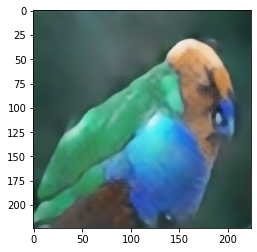

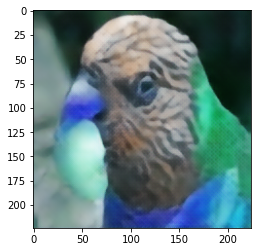

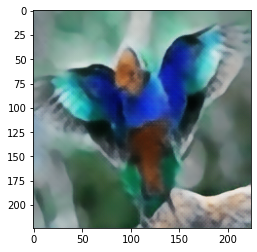

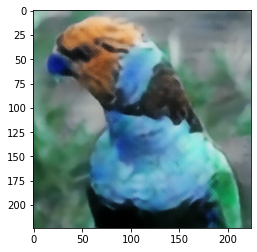

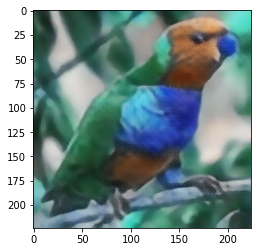

In [ ]:
if Validating:
    for i in range(5):
        trainer.generate(epoch = i, show = True, temp=1.3)